## Load data

In [1]:
from ModelNet10PointNetDataset import ModelNet10PointNetDataset
import torch
import numpy as np
train_dataset = ModelNet10PointNetDataset("../ModelNet10","train")

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=20, persistent_workers=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

test_data = ModelNet10PointNetDataset("../ModelNet10","test")
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)


print(f'Number of training samples: {len(train_data)}.\nNumber of validation samples: {len(val_data)} \nNumber of test samples: {len(test_data)}.')
pc, idx = train_data[0]
print(f'Size of the first point cloud: {pc.shape}')

Number of training samples: 3591.
Number of validation samples: 400 
Number of test samples: 908.
Size of the first point cloud: torch.Size([1024, 3])


In [2]:
print(train_dataset.class_to_idx)

{'bathtub': 0, 'bed': 1, 'chair': 2, 'desk': 3, 'dresser': 4, 'monitor': 5, 'night_stand': 6, 'sofa': 7, 'table': 8, 'toilet': 9}


In [ ]:
import matplotlib.pyplot as plt
def plotPointCloud(points,title):
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

    # Set equal ratio
    max_range = np.array([
        points[:, 0].max() - points[:, 0].min(),
        points[:, 1].max() - points[:, 1].min(),
        points[:, 2].max() - points[:, 2].min()
    ]).max() / 2.0

    mid_x = (points[:, 0].max() + points[:, 0].min()) * 0.5
    mid_y = (points[:, 1].max() + points[:, 1].min()) * 0.5
    mid_z = (points[:, 2].max() + points[:, 2].min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()
    plt.show()

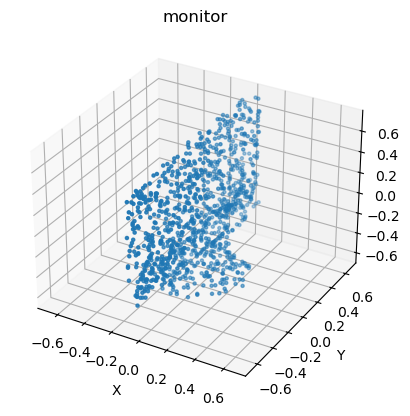

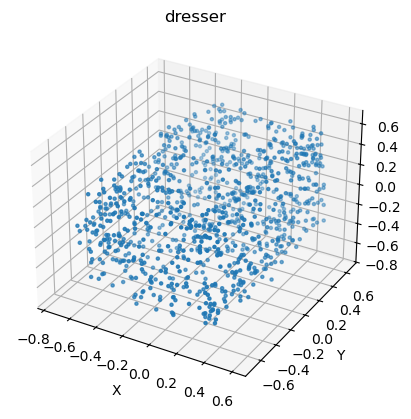

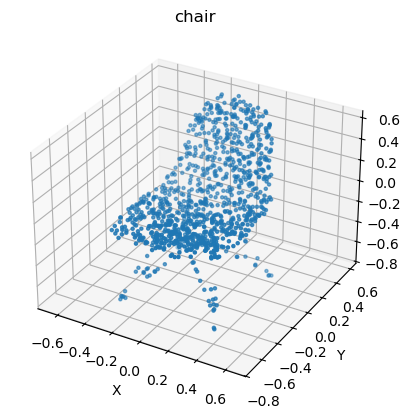

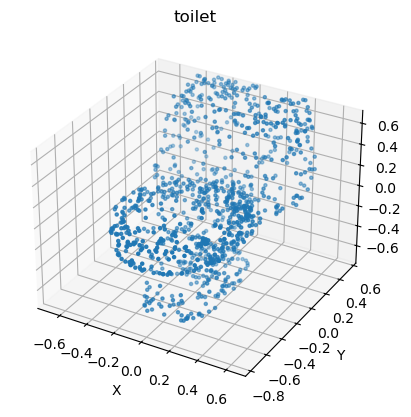

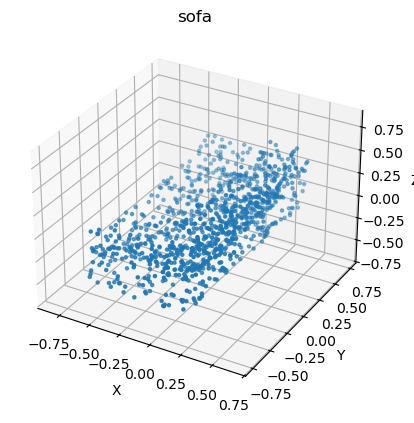

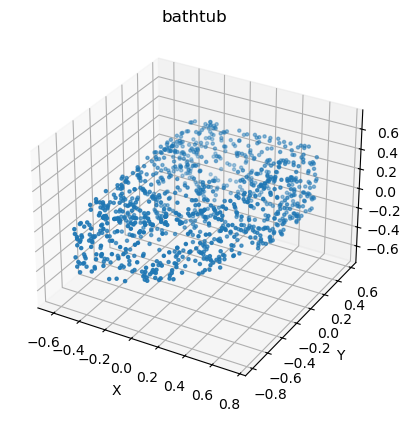

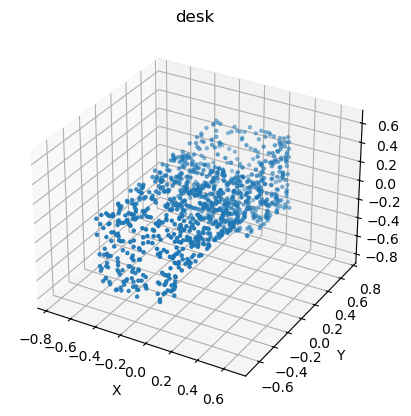

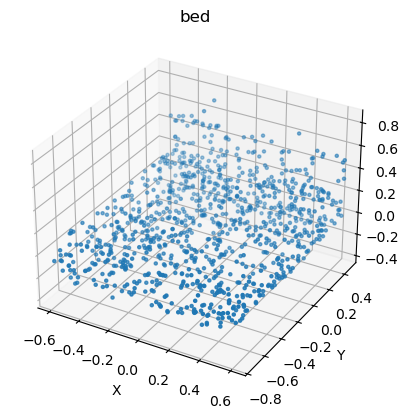

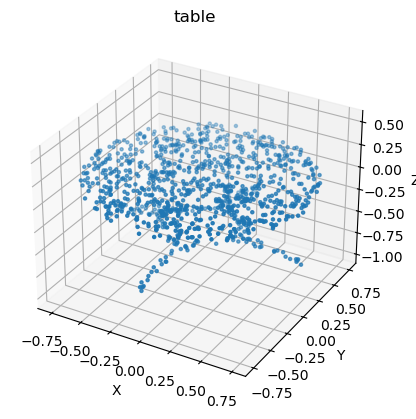

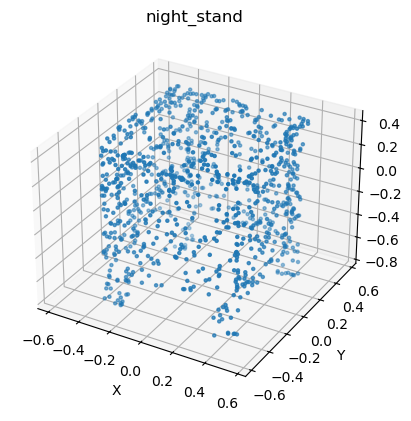

In [10]:
import numpy as np
plotted = []

for pc, label in train_loader:
    if(len(plotted) == 10): break

    #Random batch idx
    randInt = np.random.randint(0, len(pc))
    if not (label[randInt].item() in plotted):
        title = train_dataset.idx_to_class[label[randInt].item()]
        plotPointCloud(pc[randInt].squeeze(0), title)
        plotted.append(label[randInt].item())

## Train the model

Epoch [1/15], Train Loss: 0.5739, Val Loss: 0.4023
Saved best model at epoch 1 with val loss 0.4023
Epoch [2/15], Train Loss: 0.2691, Val Loss: 0.2723
Saved best model at epoch 2 with val loss 0.2723
Epoch [3/15], Train Loss: 0.1983, Val Loss: 0.2189
Saved best model at epoch 3 with val loss 0.2189
Epoch [4/15], Train Loss: 0.1678, Val Loss: 0.3524
Epoch [5/15], Train Loss: 0.1582, Val Loss: 0.1750
Saved best model at epoch 5 with val loss 0.1750
Epoch [6/15], Train Loss: 0.1389, Val Loss: 0.2363
Epoch [7/15], Train Loss: 0.1172, Val Loss: 0.2477
Epoch [8/15], Train Loss: 0.1140, Val Loss: 0.2060
Epoch [9/15], Train Loss: 0.1210, Val Loss: 0.1681
Saved best model at epoch 9 with val loss 0.1681
Epoch [10/15], Train Loss: 0.1114, Val Loss: 0.2015
Epoch [11/15], Train Loss: 0.1011, Val Loss: 0.1956
Epoch [12/15], Train Loss: 0.0856, Val Loss: 0.1540
Saved best model at epoch 12 with val loss 0.1540
Epoch [13/15], Train Loss: 0.0785, Val Loss: 0.1610
Epoch [14/15], Train Loss: 0.0763, Val

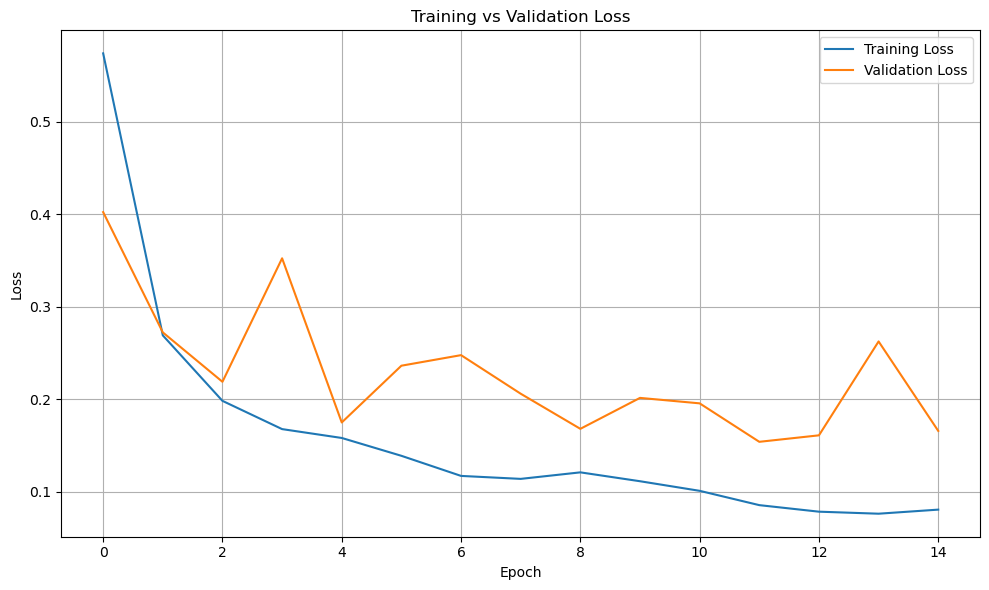

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from PointNet import PointNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pointnet = PointNet(classes=10).to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.00025) # from https://www.kaggle.com/code/balraj98/pointnet-for-3d-object-classification-pytorch#Introduction

num_epochs = 15
best_val_loss = float('inf')
save_path = 'best_pointnet_model.pth'

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    pointnet.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pointnet(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    pointnet.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pointnet(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save model if this is the best so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(pointnet.state_dict(), save_path)
        print(f"Saved best model at epoch {epoch+1} with val loss {best_val_loss:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_plot.png')
plt.show()


In [ ]:
def plot_training_validation_loss(train_loss,val_loss):
    plt.plot(np.arange(0,len(train_loss)), train_loss, label='Training loss per batch' )
    plt.plot(np.arange(0,len(val_loss)), val_loss, label='Validation loss per batch')

    plt.vlines(np.argmin(val_loss),ymin=0, ymax=max(max(train_loss),max(val_loss)), linestyle=':',colors='k', label='Minimum validation loss') 

    plt.xlabel('Epochs')
    plt.ylabel('Loss per batch')
    plt.title('Training vs validation loss')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
plot_training_validation_loss(train_losses, val_losses)

## Test the model

In [3]:
from PointNet import PointNet
pointnet = PointNet()
pointnet.load_state_dict(torch.load('best_pointnet_model.pth'))

C:\Users\eric_\AppData\Local\Temp\ipykernel_31396\797792582.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pointnet.load_state_dict(torch.load('best_pointnet_model.pth'

<All keys matched successfully>

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pointnet.eval()

correct = 0
total = 0

with torch.no_grad():
    for points, labels in test_loader:
        points, labels = points.to(device), labels.to(device)
        
        output = pointnet(points)
        predicted = torch.argmax(output, dim=1)
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 90.53%


In [6]:
from seaborn import cubehelix_palette, heatmap
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_confusion_matrix(classifier, dataloader, dataset):
    """Plot confusion matrix for PointNet."""
    confusion_matrix = np.zeros((10, 10), dtype=int)

    classifier.eval()

    with torch.no_grad():
        for points, labels in dataloader:
            points, labels = points.to(device), labels.to(device)
            logits = classifier(points)
            predicted = torch.argmax(logits, dim=1)
            for pred, label in zip(predicted, labels):
                np.add.at(confusion_matrix, (label.item(), pred.item()), 1)

    # Normalize per row (ground truth)
    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    confusion_matrix_normalized = np.divide(confusion_matrix, row_sums, where=row_sums != 0)

    # Use dataset mapper to convert integer labels to string labels.
    tick_labels = [dataset.idx_to_class[i] for i in range(len(dataset.idx_to_class))]

    plt.figure(figsize=(10, 8))
    ax = heatmap(confusion_matrix_normalized, annot=True, fmt=".2f", square=True,
                 cmap=cubehelix_palette(light=0.95, as_cmap=True), vmin=0.0, vmax=1.0)


    ax.set_xticklabels(tick_labels, rotation=45)
    ax.set_yticklabels(tick_labels, rotation=0)
    plt.xlabel("Predicted object", fontsize=15)
    plt.ylabel("Ground truth object", fontsize=15)
    plt.title("PointNet Confusion Matrix on ModelNet10", fontsize=16)
    plt.show()

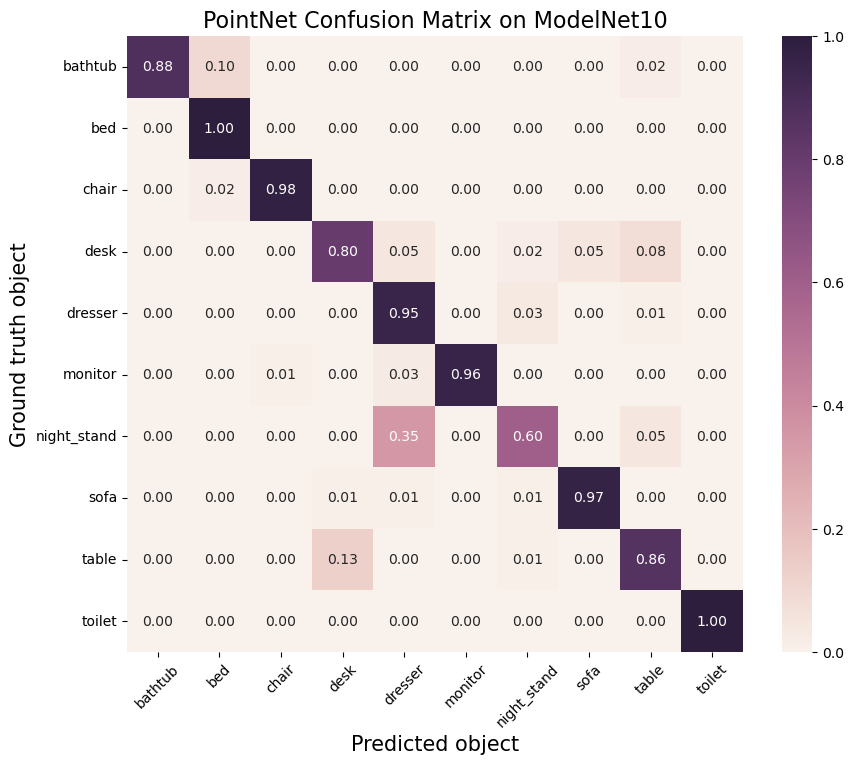

In [7]:
plot_confusion_matrix(pointnet, test_loader, test_data)

In [ ]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

trainable_params = count_trainable_params(pointnet)

print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 803338
